# 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split


# 2. Define Preprocessing and Augmentation

In [2]:
# Preprocessing for validation/test
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Augmentation for training
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# 3. Load Dataset and Split

In [3]:
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"

# Load dataset with preprocessing (for splitting)
full_dataset = datasets.ImageFolder(root=dataset_path, transform=preprocess)

# Split: 70% train, 15% val, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply augmentation to training dataset
train_dataset.dataset.transform = train_transforms

# 4. DataLoaders

In [4]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# 5. Model Setup (ResNet18 for Grayscale)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 without pretrained weights
model = models.resnet18(weights=None)  # or pretrained=False in older versions

# Modify first conv layer to accept 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the output layer to match number of classes
num_classes = len(full_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


# 6. Loss and Optimizer


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. Training Loop

In [17]:
num_epochs = 20

# Initialize tracking lists
train_losses = []
val_losses = []  
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total

    # Save training loss and accuracy
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0  # Optional
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Optional, if you want val_loss
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    val_epoch_loss = val_loss / len(val_loader.dataset)  # Optional

    # Save validation metrics
    val_accs.append(val_acc)
    val_losses.append(val_epoch_loss)  # Optional

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch [1/20], Loss: 0.3622, Train Acc: 86.14%, Val Acc: 79.59%
Epoch [2/20], Loss: 0.3446, Train Acc: 86.99%, Val Acc: 84.02%
Epoch [3/20], Loss: 0.3468, Train Acc: 86.45%, Val Acc: 84.18%
Epoch [4/20], Loss: 0.3256, Train Acc: 86.95%, Val Acc: 84.18%
Epoch [5/20], Loss: 0.3389, Train Acc: 86.65%, Val Acc: 84.81%
Epoch [6/20], Loss: 0.3341, Train Acc: 86.61%, Val Acc: 84.81%
Epoch [7/20], Loss: 0.3002, Train Acc: 88.51%, Val Acc: 83.86%
Epoch [8/20], Loss: 0.3209, Train Acc: 87.26%, Val Acc: 82.91%
Epoch [9/20], Loss: 0.3022, Train Acc: 88.24%, Val Acc: 82.12%
Epoch [10/20], Loss: 0.3090, Train Acc: 87.80%, Val Acc: 80.54%
Epoch [11/20], Loss: 0.2989, Train Acc: 88.00%, Val Acc: 76.27%
Epoch [12/20], Loss: 0.2919, Train Acc: 88.89%, Val Acc: 84.18%
Epoch [13/20], Loss: 0.2838, Train Acc: 88.78%, Val Acc: 81.33%
Epoch [14/20], Loss: 0.2940, Train Acc: 88.75%, Val Acc: 85.44%
Epoch [15/20], Loss: 0.2685, Train Acc: 89.53%, Val Acc: 85.60%
Epoch [16/20], Loss: 0.2697, Train Acc: 89.97%, V

# Plot training history

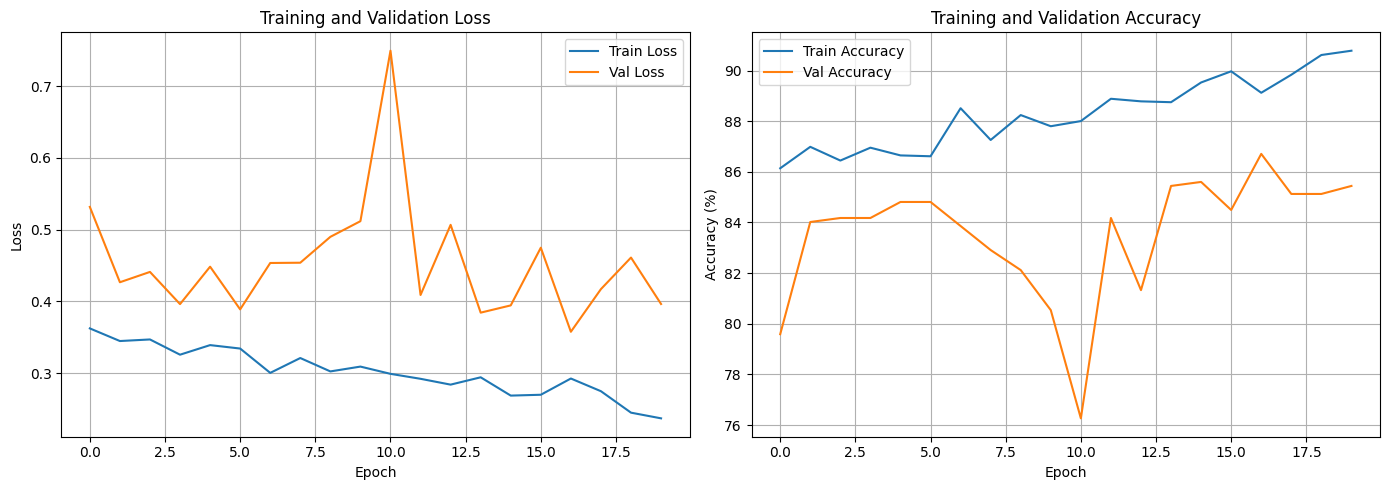

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Test the model


In [21]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [22]:
print("\nEvaluating on test set...")
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")




Evaluating on test set...
Test Loss: 0.4270, Test Accuracy: 85.96%


# Save the model

In [23]:
torch.save(model.state_dict(), 'eye_disease_model.pth')
print("\nModel saved as 'eye_disease_model.pth'")



Model saved as 'eye_disease_model.pth'


# Confusion Matrix and Classification Report


In [30]:
import os

classes = os.listdir(dataset_path)
print("Classes:", classes)

Classes: ['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']


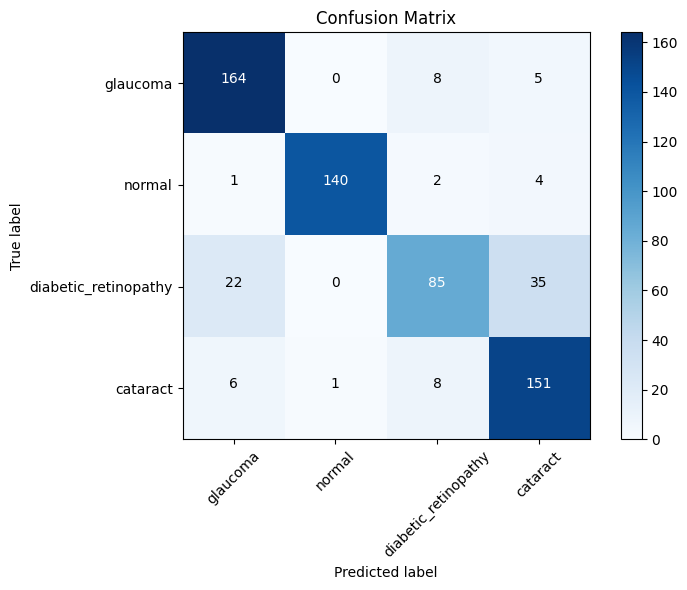


Classification Report:
                      precision    recall  f1-score   support

            glaucoma       0.85      0.93      0.89       177
              normal       0.99      0.95      0.97       147
diabetic_retinopathy       0.83      0.60      0.69       142
            cataract       0.77      0.91      0.84       166

            accuracy                           0.85       632
           macro avg       0.86      0.85      0.85       632
        weighted avg       0.86      0.85      0.85       632



In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import numpy as np

def plot_confusion_matrix(model, dataloader, classes, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))


plot_confusion_matrix(model, val_loader, classes, device)
